# Data Pre-Processing

* This Notebook details the code used to convert the .wav files into spectrograms that can be used for image recognition

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from random import gauss
from scipy.io import wavfile
import csv
from scipy import signal

In [2]:
#change the working directory to the Data directory
os.chdir("C:\\Users\\b9027741\\OneDrive - Newcastle University\\Masters\\Computer Science\\Machine_Learning_Project\\Data")

* The labels that are present in the validation set are listed below.
* Any of the other folder labels that are not present in this list are going to be classed as unknown (excluding _background_noise_)

In [3]:
#labels needed
labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence"]

## Create Silence Audio

* The silence class is currently empty and it is up to us to create files that can replicate silence.
* The _background_noise_ folder only has 6 files in it.
* We can split the audio files from the background noise into 1 second chunks and then add random gaussian noise to the data. This will create more silence audio files that can be used to train the machine learning algorithms.
* This in principle could generate an infinite number of silence samples used to train the algorithms.

In [4]:
#create the silence data files
def create_silence_audio():
    for file in os.listdir("train/audio/_background_noise_/"):
        if "wav" in file:
            sample_rate, audio = wavfile.read("train/audio/_background_noise_/"+ file)
            signal_arr = np.split(audio,np.arange(16000,len(audio),16000))
            for index, sig_arr in enumerate(signal_arr):
                for j in range(0,11):
                    signal_plus_noise = sig_arr + np.random.normal(0,1,len(sig_arr))
                    data=np.int16(signal_plus_noise/np.max(np.abs(signal_plus_noise)) * 32767)
                    filename = "noisy%d" %j + "_part%d" %index + "_%s" %file
                    wavfile.write("train/audio/silence/"+filename,16000,signal_plus_noise)
                
create_silence_audio()

C:\Users\b9027741\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## Create the Log-Spectrogram

* This spectrogram will convert our sound data into a 2D image data using a fast fourier transform (FFT).
* The function will return the frequencies and the log spectrograms

In [5]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

(161, 99)


(161, 99)

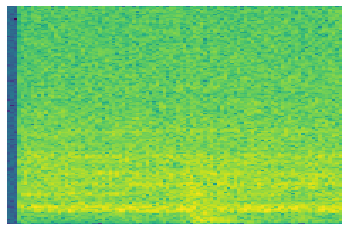

In [6]:
sample_rate, audio = wavfile.read("train/audio/yes/00f0204f_nohash_0.wav")

_, spectrogram = log_specgram(audio,sample_rate)

plt.imshow(spectrogram.T, aspect='auto', origin='lower')
plt.axis('off')

print(spectrogram.T.shape)

sample_rate, audio = wavfile.read("train/audio/silence/noisy0_part0_doing_the_dishes.wav")

_, spectrogram = log_specgram(audio,sample_rate)

plt.imshow(spectrogram.T, aspect='auto', origin='lower')
plt.axis('off')

spectrogram.T.shape

In [7]:
folder_labels = os.listdir("train/audio/")
folder_labels.remove("_background_noise_")

all_labels = [x for x in labels]

for label in folder_labels:
    if label not in all_labels:
        all_labels.append(label)
    
print(all_labels)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'training_audio_data', 'tree', 'two', 'wow', 'zero']


In [8]:
with open("train/validation_list.txt") as validation_list:
    validation_list = [row[0] for row in csv.reader(validation_list)]
    
print(len(validation_list))

for i, file in enumerate(os.listdir("train/audio/silence")):
    if i%5 == 0:
        validation_list.append("silence/"+file)

print(len(validation_list))

print(validation_list[-1])

6798
7683
silence/noisy9_part9_running_tap.wav


In [9]:
training_list = []
all_files = []
label_counts = {}

for label in all_labels:
    files = os.listdir("train/audio/" + label)
    for i, file in enumerate(files):
        all_files.append(label + "/" + file)
        file_path = label + "/" + file
        if file_path not in validation_list:
            training_list.append(file_path)
        label_counts[label] = i
        
print(label_counts)

{'yes': 2376, 'no': 2374, 'up': 2374, 'down': 2358, 'left': 2352, 'right': 2366, 'on': 2366, 'off': 2356, 'stop': 2379, 'go': 2371, 'silence': 4421, 'bed': 1712, 'bird': 1730, 'cat': 1732, 'dog': 1745, 'eight': 2351, 'five': 2356, 'four': 2371, 'happy': 1741, 'house': 1749, 'marvin': 1745, 'nine': 2363, 'one': 2369, 'seven': 2376, 'sheila': 1733, 'six': 2368, 'three': 2355, 'tree': 1732, 'two': 2372, 'wow': 1744, 'zero': 2375}


In [10]:
def wav2spec(wav_name,directory):
    
    sample_rate, samples = wavfile.read(directory + wav_name)
    
    if (len(samples) < 16000):
        samples = np.pad(samples, (0, (16000 - len(samples))), "linear_ramp")
    
    _, spectrogram = log_specgram(samples,sample_rate)
    
    return spectrogram.T

(161, 99)


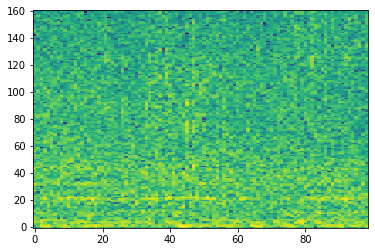

In [11]:
spec = wav2spec('silence/noisy0_part2_exercise_bike.wav',"train/audio/")
print(spec.shape)
plt.imshow(spec, aspect='auto', origin='lower')

In [12]:
def create_data_sets(file_list,directory):
    X = np.zeros([len(file_list),161,99])
    Y = np.zeros([len(file_list)])
    for index, file in enumerate(file_list):
        if index%2000 == 0:
            print(index,file)
        try:
            X[index] = wav2spec(file,directory)
        except ValueError:
            print(index,file,ValueError)
        Y[index] = all_labels.index(file.rsplit("/")[0])
        
    return X, Y
    
X_train, Y_train = create_data_sets(training_list,"train/audio/")

0 yes/004ae714_nohash_0.wav
2000 yes/f2a90886_nohash_0.wav
4000 no/e32ff49d_nohash_1.wav
6000 up/d8ee4734_nohash_1.wav
8000 down/cb8f8307_nohash_6.wav
10000 left/c1eebc0b_nohash_1.wav
12000 right/b93528e3_nohash_0.wav
14000 on/a8688b67_nohash_0.wav
16000 off/96ab6565_nohash_2.wav
18000 stop/8eb4a1bf_nohash_0.wav
20000 go/7cf14c54_nohash_0.wav
22000 silence/noisy1_part57_pink_noise.wav
24000 silence/noisy8_part0_dude_miaowing.wav
26000 bed/e652590d_nohash_0.wav
28000 cat/31d31fa0_nohash_2.wav
30000 dog/735845ab_nohash_0.wav
32000 eight/8b39e36f_nohash_0.wav
34000 five/7dc95912_nohash_2.wav
36000 four/71bf8f48_nohash_0.wav
38000 happy/87eff300_nohash_0.wav
40000 house/c6ca5d01_nohash_0.wav
42000 nine/0f3f64d5_nohash_0.wav
44000 nine/fb495c43_nohash_1.wav
46000 one/ead2934a_nohash_2.wav
48000 seven/da584bc0_nohash_1.wav
50000 six/15b0c947_nohash_1.wav
52000 three/07363607_nohash_1.wav
54000 three/f9273a21_nohash_1.wav
56000 two/2f0a410b_nohash_0.wav
58000 wow/2510c044_nohash_1.wav
60000 z

In [13]:
#all of the unknown values are 11
#where < 11 else Y_train = 11
Y_train = np.where(Y_train < 11, Y_train, 11)

#test this and see that it works
print(np.unique(Y_train))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


In [14]:
print(X_train.shape)
print(Y_train.shape)

(61460, 161, 99)
(61460,)


In [15]:
X_val, Y_val = create_data_sets(validation_list,"train/audio/")

Y_val = np.where(Y_val < 11, Y_val, 11)

print(X_val.shape)
print(Y_val.shape)

0 bed/026290a7_nohash_0.wav
2000 happy/2296b1af_nohash_1.wav
4000 right/099d52ad_nohash_1.wav
6000 up/ad63d93c_nohash_0.wav
(7683, 161, 99)
(7683,)


2.0


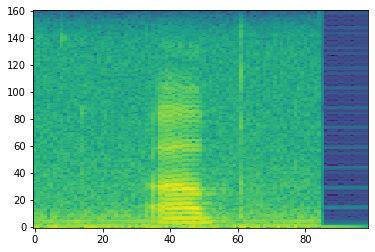

In [16]:
plt.imshow(X_train[5607], aspect='auto', origin='lower')
print(Y_train[5607])
#2.0 which corresponds to up

In [17]:
#save the data ready for the analysis
np.save("train/data/X_train", np.expand_dims(X_train,-1)+1.3)
np.save("train/data/Y_train",Y_train.astype(np.int))
np.save("train/data/X_val",np.expand_dims(X_val,-1)+1.3)
np.save("train/data/Y_val",Y_val.astype(np.int))